In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
#from sklearn.impute import KNNImputer

from pathlib import Path

Below, we import all the relevant datasets for this model. `model-training-set.csv` and `model-testing-set.csv` were generated by running `train_test_split` on `2020-2023-combined-race-training-data.csv`. `2024-combined-race-training-data.csv` was generated as a final test set to evaluate the predictive power of past years on future years.

In [2]:
cwd = Path.cwd()

TRAIN_SET_PATH = cwd / 'data/model-training-set.csv'
TEST_SET_PATH = cwd / 'data/model-testing-set.csv'
FULL_TRAIN_PATH = cwd / 'data/2020-2023-combined-race-training-data.csv'
TEST_2024_PATH = cwd / 'data/2024-combined-race-training-data.csv'

data_train = pd.read_csv(TRAIN_SET_PATH, index_col=None)
data_test = pd.read_csv(TEST_SET_PATH, index_col=None)
data_2020_2023 = pd.read_csv(FULL_TRAIN_PATH, index_col=None)
data_2024 = pd.read_csv(TEST_2024_PATH, index_col=None)

In [3]:
from xgb_model_info import features, target, best_params

Here we include the same training/validation split that was shown in model selection for reference:

In [4]:
X = data_train[features]
y = data_train[target]

X_tt, X_val, y_tt, y_val = train_test_split(X, y,
                                            train_size=0.8,
                                            shuffle=True,
                                            random_state=42)

xgb = XGBRegressor(**best_params)

xgb.fit(X_tt, y_tt)

train_preds = xgb.predict(X_tt)
val_preds = xgb.predict(X_val)

print("Train RMSE:", root_mean_squared_error(y_tt, train_preds))
print("Validation RMSE:", root_mean_squared_error(y_val, val_preds))

print("Train MAPE:", mean_absolute_percentage_error(y_tt, train_preds))
print("Validation MAPE:", mean_absolute_percentage_error(y_val, val_preds))

Train RMSE: 158.34817504882812
Validation RMSE: 460.154052734375
Train MAPE: 0.009668192826211452
Validation MAPE: 0.026251982897520065


### Let's train the model on the training set and check scores on the test set:

In [5]:
X = data_train[features]
y = data_train[target]

X_test = data_test[features]
y_test = data_test[target]

xgb = XGBRegressor(**best_params)
xgb.fit(X, y) #Fit to the reserved training set

train_preds = xgb.predict(X)
test_preds = xgb.predict(X_test)

print("Train RMSE:", root_mean_squared_error(y, train_preds))
print("Test RMSE:", root_mean_squared_error(y_test, test_preds))

print("Train MAPE:", mean_absolute_percentage_error(y, train_preds))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_preds))

Train RMSE: 182.63931274414062
Test RMSE: 409.79229736328125
Train MAPE: 0.010964780114591122
Test MAPE: 0.024626675993204117


### Now, for a final test, we retrain the model on all the data from 2020 to 2023, and test it against 2024 data:

In [6]:
X = data_2020_2023[features]
y = data_2020_2023[target]

X_test = data_2024[features]
y_test = data_2024[target]

xgb = XGBRegressor(**best_params)
xgb.fit(X, y) #Fit chosen model to the full training set

train_preds = xgb.predict(X)
test_preds = xgb.predict(X_test)

print("Train RMSE:", root_mean_squared_error(y, train_preds))
print("Test RMSE:", root_mean_squared_error(y_test, test_preds))

print("Train MAPE:", mean_absolute_percentage_error(y, train_preds))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_preds))

Train RMSE: 202.42869567871094
Test RMSE: 944.5324096679688
Train MAPE: 0.012157672084867954
Test MAPE: 0.05588880926370621


### Residuals vs predictions plot for the previous model:

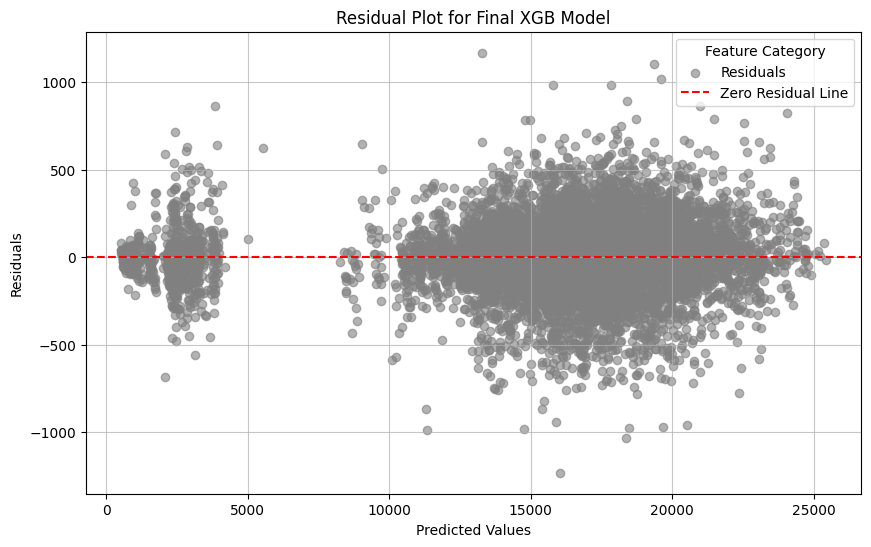

In [7]:
import matplotlib.pyplot as plt

residuals = y - train_preds

plt.figure(figsize=(10, 6))
plt.scatter(train_preds, residuals, alpha=0.6, label="Residuals", color='gray')
plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title(f"Residual Plot for Final XGB Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(title="Feature Category")
plt.grid(alpha=0.7)
plt.show()

### Residuals vs predicted values on the 2024 test set:

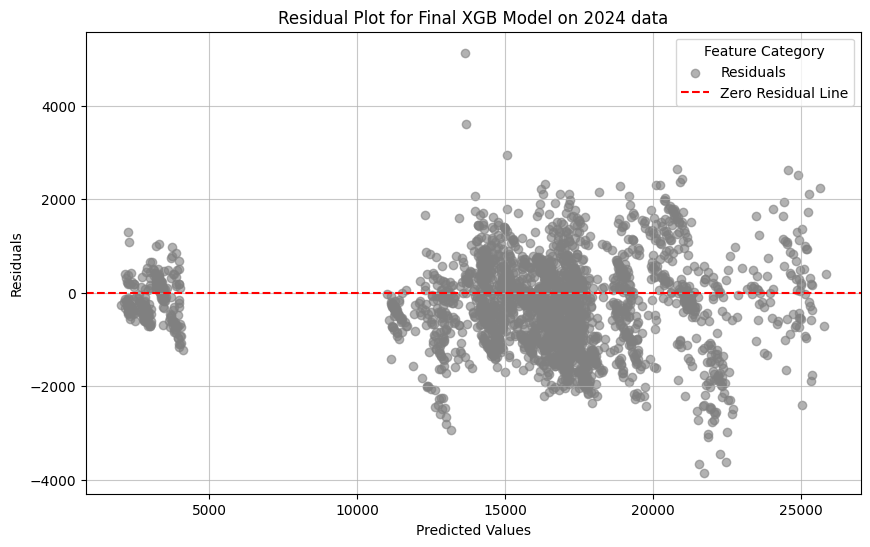

In [9]:
residuals = y_test - test_preds

plt.figure(figsize=(10, 6))
plt.scatter(test_preds, residuals, alpha=0.6, label="Residuals", color='gray')
plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
plt.title(f"Residual Plot for Final XGB Model on 2024 data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(title="Feature Category")
plt.grid(alpha=0.7)
plt.show()

### Feature importance scores

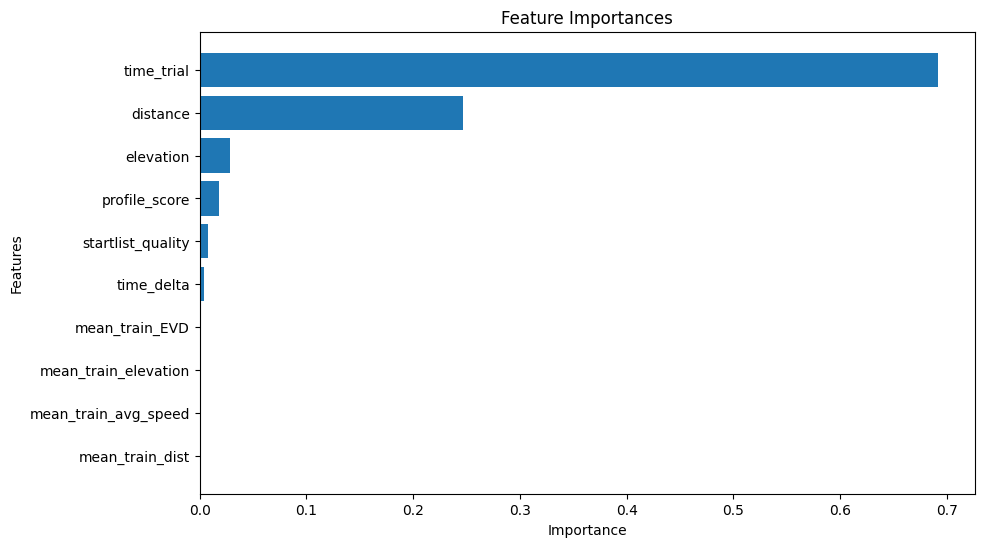

In [9]:
importances = xgb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(y=range(X.shape[1]), width=importances[indices])
plt.yticks(range(X.shape[1]), names)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()